# 주제 : 학종이만한 사진을 사진만한 크기로 확대하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
  - 이번 주제의 데이터는 portrait 데이터로 유명한 PFCN dataset을 이용합니다.
  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

  위의 이미지는 다음과 같은 것을 보여줍니다.  
- 800x600의 사람 portrait 이미지  
     - ?????.png  
- 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
- pfcn_original
     - 원본 800x600 이미지들
- pfcn_small
     - colab용 100x75 이미지들



   - 데이터 출처:
     - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
     - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)

## 최종 목표

  - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
  - 코렙에 구글 drive 연동
  - 큰 사진을 작게 줄이기
  - 이미지에 대한 오토인코더식 접근 방법

  - 출제자 : 손근영 강사


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 1. 구글 drive와 colab 연동하고 PFCN 데이터 살펴보기

In [2]:
# 구글 drive와 colab 연동하기

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# cd /content/drive/MyDrive/'Colab Notebooks'/dnn_examples/part2-/dataset

In [5]:
# !ls

In [6]:
# 데이터를 np array로 training에서 사람 이미지 한장과 영역 이미지 한장을 불러오는 코드를 작성해주세요. (x, y로 변수 대입)
import imageio
x = imageio.imread('./dataset/training/00001.png')

### 문제 2. x의 shape을 출력해보세요.

In [7]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
x.shape

(800, 600, 3)

### 문제 3. x를 plt를 통하여 출력하세요.

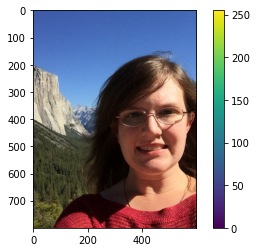

In [8]:
# x를 plt를 이용하여 출력하는 코드를 작성해보세요
plt.imshow(x)
plt.colorbar() # 0~250
plt.show()

### 문제 4. (800, 600)의 의미지는 colab에서 돌리기에 너무 큽니다. (100, 75)로 이미지를 줄여보세요

In [9]:
# x를 각각 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize
x1 = resize(x, (100,75,3))
x1.shape

(100, 75, 3)

### 문제 5. (50, 37)로 이미지를 줄여보고 출력해보세요

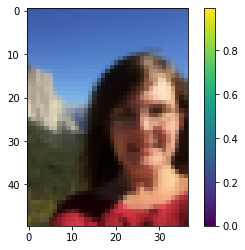

In [10]:
# x를 각각 (800, 600, 3) -> (50, 37, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
x = resize(x, (50, 37, 3))
plt.imshow(x)
plt.colorbar() # 0~1 normalization 됨
plt.show()

### 문제 6. pfcn_small.npz 데이터에서 학습, 테스트 데이터를 로드하세요.

In [11]:
# pfcn_small.npz에서 train_images, test_images를 train_big_images, test_big_images의 이름으로 np array로 로드하세요.
#https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing

# !gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

'gdown'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [12]:
pfcn_small = np.load('./dataset/pfcn_small.npz')

In [13]:
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

In [14]:
train_big_images.shape, test_big_images.shape

((1700, 100, 75, 3), (300, 100, 75, 3))

### 문제 7. train_big_images, test_big_images를 (50, 37, 3)으로 줄인 이미지를 할당하세요.

In [15]:
# train_big_images, test_big_images를 (50, 37, 3)으로 축소하고 train_small_images / test_small_images의 이름으로 할당하세요.
train_small_images = resize(train_big_images, (1700,50,37,3))
test_small_images = resize(test_big_images, (300,50,37,3))

In [16]:
train_small_images.shape, test_small_images.shape

((1700, 50, 37, 3), (300, 50, 37, 3))

### 문제 8. train_big_images에서 0이 아닌 값들을 출력해보세요.

In [17]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.
print(train_big_images[train_big_images!=0][:10])
print(train_small_images[train_small_images!=0][:10])

[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275 0.65588235
 0.25490196 0.36470588 0.66470588 0.2372549 ]
[0.24306544 0.35541527 0.65414226 0.24706882 0.35551775 0.65607215
 0.2457701  0.35606925 0.65572801 0.24647147]


### 문제 9. train_big_images의 dtype을 출력해보세요.

In [18]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
train_big_images.dtype

dtype('float64')

## Step 2. 전처리

### 문제 10. train/test_big_images 이미지 데이터의 범위 확인

In [19]:
# train/test_big_images의 shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.
print(train_big_images.shape, train_big_images.dtype)
print(train_big_images[train_big_images!=0][:10])
print('-----------------------------------')
print(test_big_images.shape, test_big_images.dtype)
print(test_big_images[test_big_images!=0][:10])

(1700, 100, 75, 3) float64
[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275 0.65588235
 0.25490196 0.36470588 0.66470588 0.2372549 ]
-----------------------------------
(300, 100, 75, 3) float64
[0.50980392 0.64117647 0.64313725 0.51568627 0.64705882 0.64901961
 0.53823529 0.65588235 0.66372549 0.52843137]


### 문제 11. images 이미지 데이터의 최소/최대값을 출력

In [20]:
# train/test 전체 데이터에서 각 images의 min, max를 출력하는 코드를 작성하세요.
print(train_big_images.min(), train_big_images.max())
print(test_big_images.min(), test_big_images.max())

0.0 1.0
0.0 1.0


## Step 3. 시각화 방법

### 문제 12. train_big_image의 이미지를 5장 획득하여 (5, 100, 75, 3)의 shape을 출력하세요.

In [21]:
# (배치, 100, 75, 3)인 train_big_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
five = train_big_images[:5]
five.shape

(5, 100, 75, 3)

### 문제 13. transpose 함수를 이용하여 (100, 75 * 5, 3)로 shape을 변경해보세요.

In [22]:
# transpose는 tensor의 axis를 섞는 기능을 합니다.
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요.
five.transpose((1,0,2,3)).reshape((100,-1,3)).shape

(100, 375, 3)

### 문제 14. (100, 375, 3)이 된 tensor를 plt로 출력해보세요.

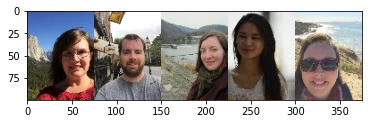

In [23]:
# (100, 375, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(five.transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

### 문제 15. small도 (50, 37 * 5, 3)으로 plt로 출력해보세요.

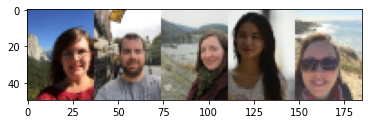

In [24]:
# (50, 37 * 5, 3)의 이미지를 plt로 출력해보세요.
five_small = train_small_images[:5]
plt.imshow(five_small.transpose((1,0,2,3)).reshape((50,-1,3)))
plt.show()

## Step 4. 모델링

### 문제 16. small 학습셋을 big으로 고해상도 변경하는 모델을 작성하세요.

In [41]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Activation, Dropout, concatenate

In [42]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [46]:
def unet_sr():
    inputs = Input((50,37,3))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    d1 = Dropout(0.1)(p1)
    
    c2 = conv2d_block(d1, 32)
    p2 = MaxPool2D(2)(c2)
    d2 = Dropout(0.1)(p2)
    
    c3 = conv2d_block(d2, 64)
    p3 = MaxPool2D(2)(c3)
    d3 = Dropout(0.1)(p3)
    
    c4 = conv2d_block(d3, 128)
    p4 = MaxPool2D(2)(c4)
    d4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(d4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(0,1))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(1,0))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)
    
    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    u10 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c9)
    outputs = Conv2D(3,1, activation='sigmoid')(u10)
    model = Model(inputs, outputs)
    return model

### 문제 17. 모델을 할당 받고 서머리를 출력해보세요.

In [47]:
# unet_resolution() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_sr()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 50, 37, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 50, 37, 16)   64          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 50, 37, 16)   0           batch_normalization_16[0][0]     
______________________________________________________________________________________________

### 문제 18. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [50]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mae', optimizer='adam', metrics=['acc'])

### 문제 19. 만든 모델에 train_small_images를 학습시켜 보세요.

In [51]:
# train_small_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(
    train_small_images,
    train_big_images,
    validation_data=(test_small_images, test_big_images),
    epochs=25,
    verbose = 1
)

Epoch 1/25
54/54 [==============================] - 35s 74ms/step - loss: 0.1990 - acc: 0.4390 - val_loss: 0.2206 - val_acc: 0.5349
Epoch 2/25
54/54 [==============================] - 2s 28ms/step - loss: 0.0870 - acc: 0.6089 - val_loss: 0.1906 - val_acc: 0.6896
Epoch 3/25
54/54 [==============================] - 2s 34ms/step - loss: 0.0708 - acc: 0.7448 - val_loss: 0.1675 - val_acc: 0.7172
Epoch 4/25
54/54 [==============================] - 2s 29ms/step - loss: 0.0618 - acc: 0.7728 - val_loss: 0.1450 - val_acc: 0.7300
Epoch 5/25
54/54 [==============================] - 2s 29ms/step - loss: 0.0597 - acc: 0.7856 - val_loss: 0.1161 - val_acc: 0.7533
Epoch 6/25
54/54 [==============================] - 2s 28ms/step - loss: 0.0572 - acc: 0.7894 - val_loss: 0.1000 - val_acc: 0.7605
Epoch 7/25
54/54 [==============================] - 2s 28ms/step - loss: 0.0571 - acc: 0.7935 - val_loss: 0.0826 - val_acc: 0.7813
Epoch 8/25
54/54 [==============================] - 2s 28ms/step - loss: 0.0558 - 

### 문제 20. 학습 진행 사항을 plt으로 출력하세요.

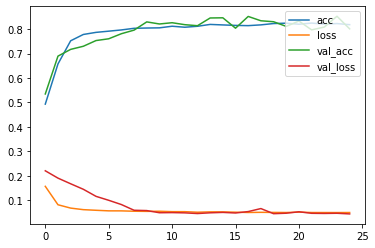

In [52]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()

## Step 5. 결과 확인

### 문제 21. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [53]:
# 모델에 test_small_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_small_images[1:2])

### 문제 22. test_small_images[1]을 resize 함수를 이용하여 (100, 75)으로 2배 확대시키세요.

In [55]:
# test_small_images[1]을 resize 함수를 이용해여 (100, 75, 3) 으로 2배 확대하는 코드를 작성하세요.
exp = resize(test_small_images[1], (100,75,3))
exp.shape

(100, 75, 3)

### 문제 23. res와 확대한 이미지, test_big_images[1]을 동시에 출력시켜 보세요.

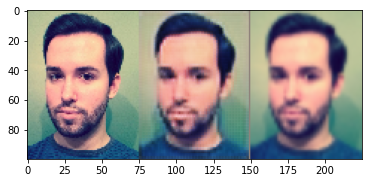

In [58]:
# res와 확대한 이미지, test_big_images[1]]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([test_big_images[1], res[0], exp], axis=1))
plt.show()

### 문제 24. 3장의 test_small_images를 모델에 넣은 뒤 결과를 문제 23 방식으로 비교하세요.

In [60]:
# 3장의 이미지를 모델에 넣고 결과를 23번 같은 방식으로 비교하는 코드를 작성하세요
three = model.predict(test_small_images[:3])

(3, 100, 75, 3)

In [61]:
exps = resize(test_small_images[:3], (3,100,75,3))
exps.shape

(3, 100, 75, 3)

In [72]:
x = np.concatenate([test_big_images[:3], three, exps], axis=2).reshape((300, -1, 3))

In [73]:
x.shape

(300, 225, 3)

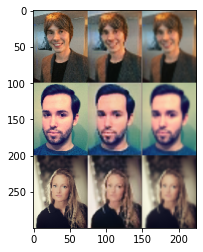

In [74]:
plt.imshow(x)
plt.show()

### 기타

그러면 주어진 shape보다 큰 사진에 sr을 하려면 어떻게 할까?

In [75]:
train_small_images.shape, test_small_images.shape

((1700, 50, 37, 3), (300, 50, 37, 3))

In [78]:
train_lr_images = resize(train_small_images, (1700,100,75,3))
test_lr_images = resize(test_small_images, (300,100,75,3))

In [79]:
train_lr_images.shape, test_lr_images.shape

((1700, 100, 75, 3), (300, 100, 75, 3))

In [94]:
from keras.layers import Average

def srcnn():
    inputs = Input((100,75,3))
    x = Conv2D(64,9,activation='relu', padding='same')(inputs)
    
    x1 = Conv2D(32,1,activation='relu', padding='same')(x)
    x2 = Conv2D(32,3,activation='relu', padding='same')(x)
    x3 = Conv2D(32,5,activation='relu', padding='same')(x)
    x = Average()([x1,x2,x3])
    
    outputs = Conv2D(3, 5, activation='relu', padding='same')(x)
    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer='adam', metrics=['acc'])
    return model    

In [95]:
model2 = srcnn()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 100, 75, 64)  15616       input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 100, 75, 32)  2080        conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 100, 75, 32)  18464       conv2d_40[0][0]                  
____________________________________________________________________________________________

In [96]:
hist2 = model2.fit(
    train_lr_images,
    train_big_images,
    validation_data=(test_lr_images, test_big_images),
    epochs=25,
    verbose=1
)

Epoch 1/25
54/54 [==============================] - 3s 37ms/step - loss: 0.1773 - acc: 0.4806 - val_loss: 0.0690 - val_acc: 0.7711
Epoch 2/25
54/54 [==============================] - 1s 24ms/step - loss: 0.0697 - acc: 0.7657 - val_loss: 0.0593 - val_acc: 0.8197
Epoch 3/25
54/54 [==============================] - 1s 24ms/step - loss: 0.0631 - acc: 0.7871 - val_loss: 0.0574 - val_acc: 0.7703
Epoch 4/25
54/54 [==============================] - 1s 25ms/step - loss: 0.0564 - acc: 0.8004 - val_loss: 0.0466 - val_acc: 0.8259
Epoch 5/25
54/54 [==============================] - 1s 24ms/step - loss: 0.0494 - acc: 0.8212 - val_loss: 0.0589 - val_acc: 0.8313
Epoch 6/25
54/54 [==============================] - 1s 24ms/step - loss: 0.0508 - acc: 0.8138 - val_loss: 0.0433 - val_acc: 0.7921
Epoch 7/25
54/54 [==============================] - 1s 24ms/step - loss: 0.0458 - acc: 0.8069 - val_loss: 0.0402 - val_acc: 0.8349
Epoch 8/25
54/54 [==============================] - 1s 24ms/step - loss: 0.0436 - a

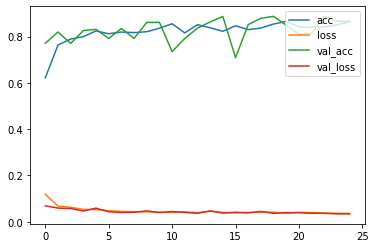

In [97]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist2.history['acc'], label='acc')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_acc'], label='val_acc')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


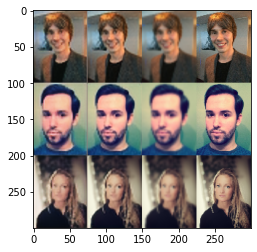

In [100]:
res2 = model2.predict(test_lr_images[:3])
imgs = np.concatenate([three, res2, test_lr_images[:3], test_big_images[:3]], axis=2).reshape((300,-1,3))
plt.imshow(imgs)
plt.show()

## Step 6. 모델 저장 및 로드, 다운

### 문제 25. 모델을 저장하세요.

In [101]:
# 모델을 저장하는 코드를 작성하세요.
model2.save('./srcnn.h5')

### 문제 26. 모델 파일을 새로운 모델에 로드하세요.

In [102]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./srcnn.h5')

### 문제 27. 로드한 모델을 test 데이터로 평가해보세요.


In [103]:
# 로드한 모델을 test 데이터로 평가해보세요.
loss, acc = new_model.evaluate(test_lr_images, test_big_images)

10/10 [==============================] - 0s 9ms/step - loss: 0.0341 - acc: 0.8665


### 문제 28. 모델을 내 컴퓨터에 저장해보세요

In [37]:
# 모델을 내 컴퓨터에 저장해보세요.